<a href="https://colab.research.google.com/github/abhinandanarya06/OCR/blob/master/Research_Notebook_on_OCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **OCR Model Training**




###**Installing and Importing Required Libraries**


---



1. OpenCV - Image Processing Library
2. Tensorflow 2.0 - Machine learning Library

In [1]:
from IPython.display import clear_output
import cv2 
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

clear_output()

###**Getting The DATASET from the repository**


---


This will clone git repository. The hierarchy of this repository as shown below:

          OCR -+-> data -----+--> a
               |             +--> b
               +-> other     :
                   files     :
                             +--> noise
                             

In [2]:
!git clone https://github.com/abhinandanarya06/OCR.git

Cloning into 'OCR'...
remote: Enumerating objects: 143, done.
remote: Counting objects: 100% (143/143), done.
remote: Compressing objects: 100% (125/125), done.
remote: Total 19489 (delta 40), reused 65 (delta 17), pack-reused 19346
Receiving objects: 100% (19489/19489), 89.86 MiB | 34.21 MiB/s, done.
Resolving deltas: 100% (13288/13288), done.
Checking out files: 100% (48544/48544), done.


###**Function to show image**


---


"***imshow(image)***" function show image given as parameter

In [3]:
def imshow(image):
  plt.imshow(image, cmap = 'gray', interpolation = 'bicubic')
  plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
  plt.show()

###**Mapping Letters classes to numbers**
Keywords contains letters with appropriate index number mapping

In [4]:
keywords = [chr(c) for c in range(ord('a'), ord('z')+1)]
cap = ['A', 'B', 'D', 'E', 'F', 'G', 'H', 'I', 'L', 'M', 'N', 'Q', 'R', 'T']
keywords = keywords + cap
keywords = keywords + ['noise']

In [5]:
print('No of text classification classes taken : ', len(keywords))

No of text classification classes taken :  41


###**Preparing Data for Training**

---
Using Tensorflow input data pipeline API (tf.data)


In [6]:
data_images = list()
labels = list()
i = 0
for c in keywords:
    path = 'OCR/data/{}/'.format(c) # IF YOU WANT TO GET DATA FROM OTHER PATH,
    files = os.listdir(path)        # THEN PLEASE MODIFY "path" VARIABLE ACCORDINGLY
    for name in files:
        img = cv2.imread(path+name, 0)
        try:
            img = cv2.resize(img, (30, 30), interpolation = cv2.INTER_AREA)
        except:
            continue
        img = img / np.max(img.reshape(900)) # Pixel feature normalization
        data_images.append([img])
        labels.append(i)
    i += 1


**Converting data to numpy array for reshaping**

In [7]:
data_images = np.array(data_images)
labels = np.array(labels)

DATASET_SIZE = labels.shape[0]
IMAGE_DATA_SHAPE = (DATASET_SIZE, 30, 30, 1)

data_images = data_images.reshape(IMAGE_DATA_SHAPE)

In [8]:
print('Image Data Shape : ', data_images.shape)
print('Labels Data Shape : ', labels.shape)

Image Data Shape :  (48528, 30, 30, 1)
Labels Data Shape :  (48528,)


**Converting to tf.data.Dataset type**

---



In [9]:
BATCH_SIZE = 1000

dataset = tf.data.Dataset.from_tensor_slices((data_images, labels))
dataset = dataset.shuffle(DATASET_SIZE)

VAL_SIZE = int(DATASET_SIZE * 0.2)

val_data = dataset.take(VAL_SIZE).batch(VAL_SIZE)
train_data = dataset.batch(BATCH_SIZE)

**Looking into dataset**

---



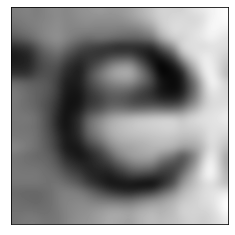

             e



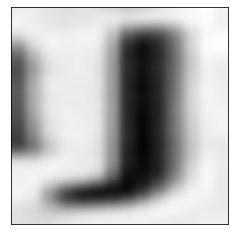

             j



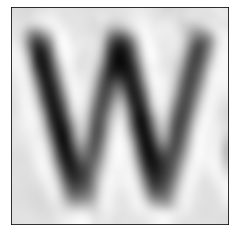

             w



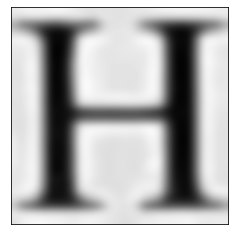

             H



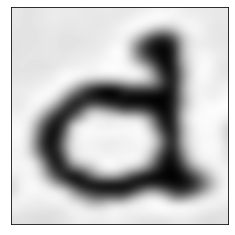

             d



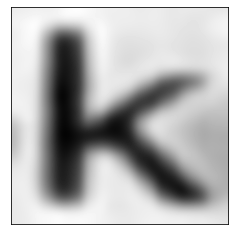

             k



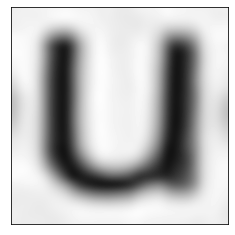

             u



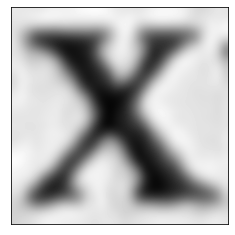

             x



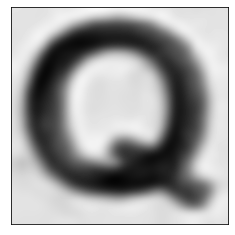

             Q



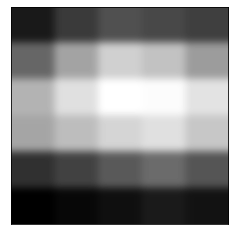

             noise



In [10]:
for img, label in train_data.take(10):
  imshow(img[0].numpy().reshape((30, 30))*255)
  print(' '*12, keywords[label[0]], end='\n\n')


###**Text Detector Model Architecture**


---


Layer Sequence (Sequencial Model) : 


1.   Conv2D Layer
2.   Flatten Operation
3.   Dense Layer with 200 units
4.   10% neuron Dropout Operation
5.   Dense Layer with keyword length units




In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(8, (5, 5), activation='relu', input_shape = (30, 30, 1)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(200, activation = 'relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(len(keywords))
])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 8)         208       
_________________________________________________________________
flatten (Flatten)            (None, 5408)              0         
_________________________________________________________________
dense (Dense)                (None, 200)               1081800   
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 41)                8241      
Total params: 1,090,249
Trainable params: 1,090,249
Non-trainable params: 0
_________________________________________________________________


**Training starts with callback of early stopping with patience 3**

---



In [13]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
history = model.fit(train_data, epochs=10, callbacks = [callback], validation_data=val_data)
clear_output()

**Training Analysis**

---



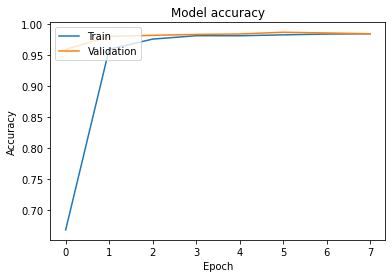

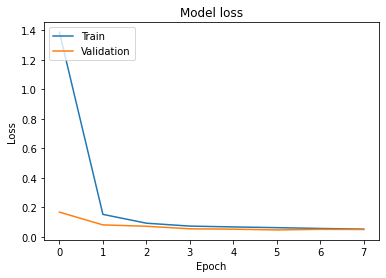

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()



---


---





# **OCR Model Testing**


 

###**Saving the trained model**


---

'model' model is saved in current directory with name 'model.hd5'


In [16]:
model.save('model.h5')
clear_output()

### **Load Model**

---

from github repo

In [26]:
model = tf.keras.models.load_model('OCR/model.h5') # change it for your preference

### **OCR Deployment Demo (Testing Model)**


---



#####**Some Conventions**

In [18]:
X = 0   # X coordinate of the character in image space
Y = 1   # Y coordinate of the character in image space
POS = 1    # shows and return the (x,y) coordinate of image space
SHAPE = 2  # shows and return the (width, height) of character contour in image space
W = 0 # width of the character
H = 1 # height of the character

#####"***check_in(c, region)***" checks if character is present in the given region "*region*" of the image space

In [19]:
def check_in(c, region):
    x, y, w, h = region
    center_x = c[POS][X]+c[SHAPE][W]/2
    center_y = c[POS][Y]
    if (center_x > x-1 and center_x < x+w+1) and (center_y > y-1 and center_y < y+h+1):
        return True
    return False

#####"***get_region(c, regions)***" finds the region in the given list of regions "*regions*" in image space and return it

In [20]:
def get_region(c, regions):
    for region in regions:
        if check_in(c, region):
            return region
    return False

#####"***sort_chars(line)***" Function to sort characters in given line

In [21]:
def sort_chars(line):
    return sorted(line, key=lambda c: c[POS][X])

#####"***sort_lines_by_yval(lines)***" function sorts list of lines according to its y coordinate in image space

In [22]:
def sort_lines_by_yval(lines):
    return sorted(lines, key=lambda line: line[0][POS][Y])

#####"***group_chars_by_line(characters)***" Function to group characters in given image by lines

In [23]:
def group_chars_by_line(characters):
  lines = list()
  while len(characters) > 0:
      m = characters[0]
      my = m[1][1]
      my_plus_h = m[1][1]+m[2][1]
      lines.append([m])
      for c in characters[1:]:
          if my <= c[POS][Y]+c[SHAPE][H]/2 and c[POS][Y]+c[SHAPE][H]/2 <= my_plus_h:
              if my > c[POS][Y]:
                  my = c[POS][Y]
              if my_plus_h < c[POS][Y]+c[SHAPE][H]:
                  my_plus_h = c[POS][Y]+c[SHAPE][H]
              lines[-1].append(c)
              characters.remove(c)
      lines[-1]= sort_chars(lines[-1])
      characters.remove(m)
  return lines

#####"***apply_ocr(img, text_detector_model)***" is the function that does actual ocr operation on image parameter to get text

In [24]:
def apply_ocr(img, text_detector):
    avg_text_height = 0 # will be assigned with Average Height of text character
    character_list = list() # will contain necessary text character to be extracted
    img = cv2.medianBlur(img,5)
    img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,41,10) # will remove maximum noise and make image suitable for contour dt
    contours, hierarchy = cv2.findContours(img,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    black_map = img.copy()
    black_map[:, :] = 0
    i = 0
    for contour in contours:
        try:
            x,y,w,h = cv2.boundingRect(contour)
            try:
                cnt = img[y-2:y+h+2, x-2:x+w+2]
            except:
                cnt = img[y:y+h, x:x+w]
            cnt = cv2.resize(cnt, (30, 30), interpolation = cv2.INTER_AREA)
            cnt = cnt.reshape((1, 30, 30, 1))
            cnt = cnt / np.max(cnt.reshape(900))
            class_pred = np.argmax(text_detector.predict(cnt))
            if class_pred < 40:
                avg_text_height += h
                cv2.rectangle(black_map, (x-w//7,y), (x+w+w//7, y+h), 255, -1)
                character_list.append([keywords[class_pred], (x,y), (w,h)])
                i += 1
        except:
              continue
    avg_text_height /= i # Average Height of text character
    text = group_chars_by_line(character_list)
    text = sort_lines_by_yval(text)
    contours, hierarchy = cv2.findContours(black_map, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    regions = list() # will contain regions of words for grouping chars by word
    for contour in contours:
        region = cv2.boundingRect(contour)
        if region[SHAPE + H] <= avg_text_height*7:
          regions.append(region)
    del contours

    TEXT = ''
    for l in text:
        char = l[0]
        region = get_region(char, regions)
        if not region:
            continue
        for char in l:
            if not check_in(char, region):
                TEXT = TEXT + ' '
                r = get_region(char, regions)
                if not r:
                    continue
                region = r
            TEXT = TEXT + char[0]
        TEXT = TEXT + '\n'
    return TEXT

#####**Main Run Start Point**

---



* Before running this start point, Please check if 
 *test_image_path* variable have path to your own test images or not.
* If not, please modify the path variable

****************************** Text on 2-cropped.jpg ******************************


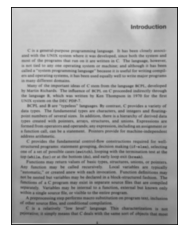

IntroductIon
c Is a general purpose programmlng language It has been closely assocl
ated wth the uNIx system where lt was developed sInce both the system and
most of the programs that run on I t are wrltten In c The language however
ls not tIed to any one operatlng system or machlne and although It has been
lled a isystem programmIng language because lt ls useful for wrItlng compIl
ers Ld operatlng systems lt has becen used equally well to wrlte major programs
m many dlfferent domalns
Many of the lmportant ldeas of c stem from the language BcpL developed
by MItln RIchards The lnHuence of BcpL on c proceeded lndIrectly through
the l guage B whIch was wrltten by ken Thompson ln l pTo for the rst
Ix system on the DEc pDp T
BcpL and B are typeless languages By contrast c provldes a varlety of
data types The fundamental types are characters and lntegers and goatlng
pomt numbers of several slzes In addltlon there ls a hlerarchy of derIved data
t es created wIth poInters arrays structures and

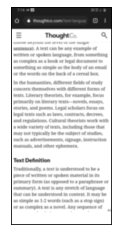

o ie
gi o e e e e e eg g
Thoughtco
ti iuoc ucyui iu i ic ic v ci ui i ic oi i iBic
sentencej A text can be aI y example of
wrltten or spoken lcangucage from somethlng
as complex as a book or legal documeI t to
somethlng as slmple cas the body of an emal l
or the words on tl e bcack of a cereal box
In the humaI ltles dlfferent flelds of study
conceI n themselves wlth dlffeI eI t forms of
texts Llterary theoI lsts for example focus
pI lmcaI lly on llteI ary texts novels essays
storles aI d poems Legal scholars focus on
legal texts sucl as laws contracts decrees
and regulatlons cultuI al theoI lsts woI k wltl
a wlde vaI lety of texts lncludlI g those that
may not typlcal ly be the subject of studles
such cas advert lsements slgnage lnst ruct lon
manucals cand otl er epl emeI a
Text De nItion
TradltloI cally ca text ls understood to be a
plece of wI ltten or spokeI materlal ln lts
pI lmcaI y form as opposed to a pcaI aphrase or
summary A text ls cany stI etch of lcanguage
that can be under

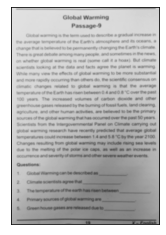

GIobaI warmI ng
passage g
Globai warming is the term used to describe a graduai increase in
the average temperature of the Eadh s atmosphere and its oceans a
change that is bei ieved to be permanentIy changing the Ea h s ci imate
There s great debate among many peopie and sometimes in the news
on whether gIobal warming is reai some cai l it a hoax But climate
scientists iooking at the data and facts agree the pianet is warming
whiIe many view the eeects of giobai warming to be more substantiai
and more rapidiy occurring than others do the scienti ic consensus on
cl imatic changes related to giobat warming Is that the average
temperature of the Ea h has risen be een o and o B oc over the past s
j oo years The increased voiumes of carbon dioxide and other
greenhouse gases reIeased by the burning of fossi i fueis Iand ciearing
agriculture and other human activities are beI ieved to be the prima
sources of the giobal warming that has occurred over the past bo years
scientists from the Inte

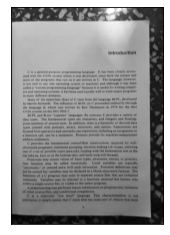

j
F
zp
r r
F
j a F i
v
l a
e F
I j
N
N
F r
r
j p
j
N
j l
y j
N
h j Ns N
a a
F
NN
T
l
a
a l
T
F
N
N
F
l D
p
j
i
j
z j
c
N
IntroductIon r
a
k
T
s y
a
N
s
N
c ls a general purpose programmIng language It has been closely assocl N
t
y
ated nth the uNIx system vvhere lt was developed sInce both the system and t s e
r
F
j
N
yz
t f the programs that r t rItten In c The lan age however l a
mos o un on I are w
eT
a l
l
F
N g
N
ls not tled to any one operatlng system or machlne and although It has been y
lled a isystem programmlng language because It ls useful for wrltlng compll
ers and operatlng systems lt has been used equally well to wrlte major programs N N NN
dfft d F
a
ln many leren omalns
N
Many of the lmportant Ideas of c stem from the language BcpL developed
by Mrtln Rlchards The lnquence of BcpL on c proceeded lndIrectly through
thc l B hh tt b ken Thompson In l pTo for the rst N v
e guage wIc was wrlen y
Ix sstem on the DEc pDp T N
y
a
y
BcpL and B are typeless languages By contrast c

In [27]:
test_images_path = 'OCR/sample_test_image/' # IF YOU PLACE TEST IMAGE INSIDE OCR DIRECTORY,
                                            # THEN PLEASE MODIFY "test_images_path" variable


imgs = [f for f in os.listdir(test_images_path) if f.endswith('.jpg')]

for img in imgs:
    print('*'*30, 'Text on {}'.format(img), '*'*30)
    img = cv2.imread(test_images_path + img, 0)
    TEXT = apply_ocr(img, model)
    imshow(img)
    print(TEXT)
    print('-'*80, '\n\n')